### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


## Research

Baseline: model from seminar, extended trainig period

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from ds_utils.torch_utils import (
    train_val_test_split,
    Apply, map_idx
)
from ds_utils.train import EarlyStopper, State
from ds_utils.plotter import History
from ds_utils.utils import map

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.feature_extraction import DictVectorizer
import nltk


%matplotlib inline

### Idea E, early stopper, plotting learning curves

In [3]:
EarlyStopper??

Init signature:
EarlyStopper(
    state: ds_utils.train.State,
    loss: str = 'loss',
    patience: int | None = 3,
    min_delta: float = 0,
) -> None
Docstring:      EarlyStopper(state: ds_utils.train.State, loss: str = 'loss', patience: int | None = 3, min_delta: float = 0)
Source:        
@dataclass
class EarlyStopper:
    state: State
    loss: str = "loss"
    patience: int | None = 3
    min_delta: float = 0
    
    def __post_init__(self):
        self.best_epoch: int = -1 if not len(self.state.history) else self.get_losses().argmin() + 1
        self.best_loss = np.inf if not len(self.state.history) else self.get_losses().min()
        
    def __str__(self):
        if self.loss.startswith("-"):
            metric = self.loss[1:]
            sign = -1
        else:
            metric = self.loss
            sign = 1
        return f"based on metric: {metric}, best epoch: {self.best_epoch}, best value: {sign * self.best_loss}"
    
    def get_losses(self):
        if self.l

### Idea C, pre-trained embeddings

### datasets, dataloaders

In [5]:

data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

############################################################
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN')

############################################################
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col]\
        .astype(str)\
        .str.lower()\
        .apply(tokenizer.tokenize)\
        .apply(' '.join)


In [6]:
data_train: pd.DataFrame
data_val: pd.DataFrame
data_test: pd.DataFrame

data_train, data_val, data_test  = train_val_test_split(data, val_size=.2, test_size=.1,
                                                        random_state=42)
for df in data_train, data_val, data_test:
    df.reset_index(drop=True, inplace=True)

In [7]:
drop_protected = ["Category", "ContractType", "ContractTime"]
assert (data_train[drop_protected].nunique() == data[drop_protected].nunique()).all()

threshold = 5
contract = ["LocationNormalized", "Company"]

for col in contract:
    mask = data_train[col].value_counts() >= threshold
    drop = mask.index[mask.values]
    for data_piece in data_train, data_val, data_test:
        data_piece[col] = data_piece[col].where(data_piece[col].isin(drop), "NaN")
    
categorical_vectorizer = DictVectorizer(dtype=bool, sparse=False)
categorical_vectorizer.fit(data_train[categorical_columns].apply(dict, axis=1));

In [8]:
from torch.utils.data.dataloader import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data: pd.DataFrame, token_to_id, UNK_IX):
        super().__init__()
        self.token_to_id = token_to_id
        self.UNK_IX = UNK_IX
        
        self.title: list[torch.Tensor]
        self.descr: list[torch.Tensor]
        self.cat: torch.Tensor
        self.target: torch.Tensor
        
        self.precompute_data(data)
    
    def precompute_data(self, data: pd.DataFrame) -> None:
        self.title = [torch.tensor([self.token_to_id.get(word, self.UNK_IX)
                                    for word in seq])
                      for seq in data["Title"].str.split()]
        self.descr = [torch.tensor([self.token_to_id.get(word, self.UNK_IX)
                                    for word in seq])
                      for seq in data["FullDescription"].str.split()]
        
        self.cat = data[categorical_columns]
        
        self.target = torch.tensor(data[TARGET_COLUMN].values)
    
    def __len__(self):
        return len(self.title)
    
    def __getitem__(self, idx: int):
        x = {attr : getattr(self, attr)[idx] for attr in ["title", "descr"]}
        x["cat"] = torch.tensor(categorical_vectorizer.transform(
            self.cat.iloc[idx][categorical_columns].to_dict()
        )[0], dtype=torch.float32)
        y = self.target[idx]
        return x, y
    

In [9]:
from torch.utils.data._utils.collate import default_collate

def as_matrix(sequences, max_len=None, min_len=5, *, PAD_IX):
    """ Convert a list of tokens into a matrix with padding """
    max_len = np.clip(max(map(len, sequences)), min_len, max_len)
    
    matrix = torch.full((len(sequences), max_len), PAD_IX, dtype=torch.int32)
    for i, seq in enumerate(sequences):
        matrix[i, :min(len(seq), max_len)] = seq[:max_len]
    
    return matrix

def collate_fn(entries, PAD_IX):
    texts = {col : as_matrix([entry[0].pop(col) for entry in entries], PAD_IX=PAD_IX)
             for col in ["title", "descr"]}
    ret = default_collate(entries)
    ret[0]["cat"] = ret[0]["cat"].to(torch.float32)
    ret[0] |= texts
    return ret

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### baseline

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, encoded_len=64):
        super().__init__()
        
        self.encoded_len = encoded_len
        outp_features = hid_size*3
        self.title_encoder = nn.Sequential(
            nn.Embedding(n_tokens, self.encoded_len),
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.encoded_len, hid_size, 3),
            nn.AdaptiveMaxPool1d(1),
            Apply(torch.squeeze, dim=-1)
        )
        self.description_encoder = nn.Sequential(
            nn.Embedding(n_tokens, self.encoded_len),
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.encoded_len, hid_size, 5, ),
            nn.AdaptiveMaxPool1d(1),
            Apply(torch.squeeze, dim=-1)
        )
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size, bias=False),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(hid_size, hid_size, bias=False)
        )
        self.output = nn.Sequential(
            nn.BatchNorm1d(outp_features),
            nn.ReLU(),
            nn.Linear(outp_features, outp_features, bias=False),
            nn.BatchNorm1d(outp_features),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(outp_features, 1),
            Apply(torch.squeeze)
        )
        
    def forward(self, batch: dict[str, torch.TensorType]):
        title_enc = self.title_encoder(batch["title"])
        descr_enc = self.description_encoder(batch["descr"])
        cat_enc = self.cat_encoder(batch["cat"])
        concat = torch.cat([title_enc, descr_enc, cat_enc], axis=1)
        return self.output(concat)
    
    def predict(self, batch):
        return self.forward(batch)

In [11]:
from collections import Counter

# Count how many times does each token occur in both "Title" and "FullDescription" in total

def baseline_tokens():
    token_counts = Counter([word
                            for line in data[text_columns].values.flatten()
                            for word in line.split()])
    min_count = 10

    # tokens from token_counts keys that had at least min_count occurrences throughout the dataset
    tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

    # Add a special tokens for unknown and empty words
    UNK, PAD = "UNK", "PAD"
    tokens = [UNK, PAD] + tokens
    token_to_id = map_idx(tokens)
    return token_to_id, 0, 1

In [ ]:
from functools import partial
base_token_to_id, base_UNK, base_PAD = baseline_tokens()
train_dataset = MyDataset(data_train, base_token_to_id, base_UNK)
val_dataset = MyDataset(data_val, base_token_to_id, base_UNK)
test_dataset = MyDataset(data_test, base_token_to_id, base_UNK)

In [23]:
batch_size = 256
config = dict(collate_fn=partial(collate_fn, PAD_IX=base_PAD), num_workers=12)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, **config)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, **config)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **config)

In [32]:
model = SalaryPredictor(len(base_token_to_id), n_cat_features=len(categorical_vectorizer.vocabulary_),
                        encoded_len=100)
model.to(device)

loss_fn = nn.MSELoss(reduction='sum')
state = State(model=model,
              optimizer=torch.optim.SGD(model.parameters(), lr=1e-4),
              history=History(drop_query="epoch < 3"),
              path="storage/hw2_base_sem.pth")

stopper = EarlyStopper(state=state, patience=5, loss="mse")

In [ ]:
%%reprint
torch.cuda.empty_cache()
num_epochs = 100
history, model, opt = state.history, state.model, state.optimizer
plotter = Plotter(bound_history=history)

params = dict(
    model=model, optim=opt, device=device,
    loss_fn=loss_fn,
    metrics=[("mse", *mean_metric(lambda y_pred, y_true: (y_pred - y_true).norm(2)**2)),
             ("mae", *mean_metric(lambda y_pred, y_true: (y_pred - y_true).norm(1)))]
)

for _ in state.history.range(num_epochs, stopper, do_tqdm=True):
    tr = loopa(**params, dataloader=train_loader, is_train=True)
    val = loopa(**params, dataloader=val_loader, is_train=False)
    history.push_epoch(tr, val)
    plotter.plot()

In [34]:
plotter.draw_no_widget()

In [ ]:
<a id="1_src" href="#1_dest"></a>

#### with pretrained embeddings

In [81]:
class SalaryPredictorFineTune(nn.Module):
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, *, embedding_layer):
        super().__init__()
        
        outp_features = hid_size*3
        self.embedding_dim = embedding_layer.embedding_dim
        self.title_encoder = nn.Sequential(
            embedding_layer,
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.embedding_dim, hid_size, 3),
            nn.AdaptiveMaxPool1d(1),
            Apply(torch.squeeze, dim=-1)
        )
        self.description_encoder = nn.Sequential(
            embedding_layer,
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.embedding_dim, hid_size, 5, ),
            nn.AdaptiveMaxPool1d(1),
            Apply(torch.squeeze, dim=-1)
        )
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size, bias=False),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size, bias=False)
        )
        self.output = nn.Sequential(
            nn.Linear(outp_features, outp_features, bias=False),
            nn.BatchNorm1d(outp_features),
            nn.ReLU(),
            nn.Linear(outp_features, 1),
            Apply(torch.squeeze)
        )
        
    def forward(self, batch: dict[str, torch.TensorType]):
        title_enc = self.title_encoder(batch["title"])
        descr_enc = self.description_encoder(batch["descr"])
        cat_enc = self.cat_encoder(batch["cat"])
        concat = torch.cat([title_enc, descr_enc, cat_enc], axis=1)
        return self.output(concat)
    
    def predict(self, batch):
        return self.forward(batch)

In [ ]:
import gensim.downloader as api
embedding_model = api.load('glove-twitter-100')

num_of_words = embedding_model.vectors.shape[0]
PAD_IX, UNK_IX = num_of_words, num_of_words + 1
token_to_id = embedding_model.key_to_index

In [ ]:
train_dataset = MyDataset(data_train, token_to_id, UNK_IX)
val_dataset = MyDataset(data_val, token_to_id, UNK_IX)
test_dataset = MyDataset(data_test, token_to_id, UNK_IX)

In [ ]:
batch_size = 256
config = dict(collate_fn=partial(collate_fn, PAD_IX=PAD_IX), num_workers=12)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, **config)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, **config)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **config)

In [25]:
embedding_layer = nn.Embedding.from_pretrained(torch.vstack([
    torch.tensor(embedding_model.vectors),
    torch.randn((2, embedding_model.vector_size))
]))

model = SalaryPredictorFineTune(n_cat_features=len(categorical_vectorizer.vocabulary_),
                                embedding_layer=embedding_layer)
model.to(device)

loss_fn = nn.MSELoss(reduction='sum')
state = State(model=model,
              optimizer=torch.optim.SGD(model.parameters(), lr=1e-4),
              history=History(drop_query="epoch < 3"),
              path="storage/hw2_embed.pth")

stopper = EarlyStopper(state=state, patience=5, loss="mse")

/home/photon/PyProjects/nlp_course/week02_classification/ds_utils/train.py:120: UserWarning:

Saver: storage/hw2_embed.pth already exists!



In [ ]:
%%reprint
torch.cuda.empty_cache()
num_epochs = 100
history, model, opt = state.history, state.model, state.optimizer
plotter = Plotter(bound_history=history)

params = dict(
    model=model, optim=opt, device=device,
    loss_fn=loss_fn,
    metrics=[("mse", *mean_metric(lambda y_pred, y_true: (y_pred - y_true).norm(2)**2)),
             ("mae", *mean_metric(lambda y_pred, y_true: (y_pred - y_true).norm(1)))]
)

for _ in state.history.range(num_epochs, stopper, do_tqdm=True):
    tr = loopa(**params, dataloader=train_loader, is_train=True)
    val = loopa(**params, dataloader=val_loader, is_train=False)
    history.push_epoch(tr, val)
    plotter.plot()

In [27]:
plotter.draw_no_widget()

#### with attention

In [11]:
def collate_fn_with_mask(entries, PAD_IX):
    texts = {}
    for col in ["title", "descr"]:
        texts[col] = as_matrix([entry[0].pop(col) for entry in entries], PAD_IX=PAD_IX)
        texts[f"{col}_mask"] = texts[col] == PAD_IX
             
    ret = default_collate(entries)
    ret[0]["cat"] = ret[0]["cat"].to(torch.float32)
    ret[0] |= texts
    return ret

In [12]:
import gensim.downloader as api
embedding_model = api.load('glove-twitter-100')

num_of_words = embedding_model.vectors.shape[0]
PAD_IX, UNK_IX = num_of_words, num_of_words + 1
token_to_id = embedding_model.key_to_index

In [13]:
train_dataset = MyDataset(data_train, token_to_id, UNK_IX)
val_dataset = MyDataset(data_val, token_to_id, UNK_IX)
test_dataset = MyDataset(data_test, token_to_id, UNK_IX)

In [14]:
from functools import partial
batch_size = 256
config = dict(collate_fn=partial(collate_fn_with_mask, PAD_IX=PAD_IX), num_workers=12)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, **config)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, **config)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **config)

In [32]:
class AttentivePooling(nn.Module):
    def __init__(self, num_channels, num_heads, output_dim):
        super().__init__()
        assert not output_dim % num_heads
        self.head_size = output_dim // num_heads
        self.num_heads = num_heads
        self.pre_attention = nn.Sequential(
            nn.BatchNorm1d(num_channels),
            nn.ReLU()
        )
        self.attention_weights = nn.Linear(num_channels, num_heads)
        self.values = nn.Linear(num_channels, output_dim)
        
    def forward(self, X: torch.Tensor, mask):
        # X: B x C x L -> B x OutputDim x 1
        X = X.permute((0, 2, 1))
        att_weights = self.attention_weights(X)
        att_weights[mask] =  -torch.inf
        att_weights = att_weights.softmax(1)
        
        values = self.values(X)
        pool_results = []
        values = values.permute((0, 2, 1))
        for i in range(self.num_heads):
            pool_results.append(values[:, self.head_size * i : self.head_size * (i + 1), :] @ \
                                att_weights[..., i:i+1])
        pool_results = torch.hstack(pool_results).squeeze(-1)
        pool_results[pool_results.isnan()] = 0
        return pool_results

class PredictionWithADHD(nn.Module):
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, num_heads=3, *, embedding_layer):
        super().__init__()
        self.embedding_dim = embedding_layer.embedding_dim
        
        self.title_before_pooling = nn.Sequential(
            embedding_layer,
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.embedding_dim, hid_size, 3)
        )
        self.title_pooling = AttentivePooling(hid_size, num_heads, hid_size * num_heads)
        
        self.descr_before_pooling = nn.Sequential(
            embedding_layer,
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(self.embedding_dim, hid_size, 5)
        )
        self.descr_pooling = AttentivePooling(hid_size, num_heads, hid_size * num_heads)
        
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size, bias=False),
            nn.BatchNorm1d(hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size, bias=False)
        )
        outp_features = hid_size*num_heads*2 + hid_size
        
        self.output = nn.Sequential(
            nn.BatchNorm1d(outp_features),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(outp_features, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(1024, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(1024, 1),
            Apply(torch.squeeze)
        )
        
    def forward(self, batch: dict[str, torch.TensorType]):
        title_enc = self.title_before_pooling(batch["title"])
        title_enc = self.title_pooling(title_enc, batch["title_mask"][:, 1:-1])
        
        descr_enc = self.descr_before_pooling(batch["descr"])
        descr_enc = self.descr_pooling(descr_enc, batch["descr_mask"][:, 2:-2])
        
        cat_enc = self.cat_encoder(batch["cat"])
        
        concat = torch.cat([title_enc, descr_enc, cat_enc], axis=1)
        return self.output(concat)
    
    def predict(self, batch):
        return self.forward(batch)

In [33]:
embedding_layer = nn.Embedding.from_pretrained(torch.vstack([
    torch.tensor(embedding_model.vectors),
    torch.randn((2, embedding_model.vector_size))
]))

model = PredictionWithADHD(n_cat_features=len(categorical_vectorizer.vocabulary_),
                                embedding_layer=embedding_layer)
model.to(device)

loss_fn = nn.MSELoss(reduction='sum')
state = State(model=model,
              optimizer=torch.optim.Adam(model.parameters(), lr=1e-4),
              history=History(drop_query="epoch < 3"),
              path="storage/hw2_attention.pth")

stopper = EarlyStopper(state=state, patience=7, loss="mse")

In [ ]:
%%reprint
torch.cuda.empty_cache()
num_epochs = 100
history, model, opt = state.history, state.model, state.optimizer
plotter = Plotter(bound_history=history)

params = dict(
    model=model, optim=opt, device=device,
    loss_fn=loss_fn,
    metrics=[("mse", *mean_metric(lambda y_pred, y_true: (y_pred - y_true).norm(2)**2)),
             ("mae", *mean_metric(lambda y_pred, y_true: (y_pred - y_true).norm(1)))]
)

for _ in state.history.range(num_epochs, stopper, do_tqdm=True):
    tr = loopa(**params, dataloader=train_loader, is_train=True)
    val = loopa(**params, dataloader=val_loader, is_train=False)
    history.push_epoch(tr, val)
    plotter.plot()

# Ideas

### A short report

(In used plots, first 2 epochs are dropped (for better plot scale) and denoted as stars. If you are able to interact with `plotly`, hovering over the stars will show the true value)

#### Optimizing (D):

1) first step was to create dataloader, which precomputes token indices

It didn't work for baseline: time for one epoch decreased from 30 s (in seminar) to 26 s, but the size of `train` also was decreased from 80% to 70%

2) second step was to do early stopping. Implementation is in `EarlyStopping` class.

#### Pretrained embeddings (C):

`glove-twitter-100` from gensim was used. The first model was like the base model but with replaced embedding layers (both are pointing towards the same layer, initialized from glove). The metrics turned out to be worse, so I <s>started crying</s> removed some layers from the model, namely all dropouts and first batchnorm with relu from the MLP (which works with the concatenated results of 2 convolutions and categorical features).

It "converged" to a bit better result than baseline: `mse=0.0693` vs `0.0743` in baseline, which is, meh. Also, the learning curves were extremely jaggy at the start.

The obvios thing to change would be aggregation from the convolution layer, because `GlobalMaxPooling` was used, which doesn't allow good embedding training/finetuning (and `GlobalAveragePooling` just )

#### Different pooling(D)
First of all, I realized that I haven't use mask for global average pooling, which could've been the reason for its bad performance.

In the next model, I used somewhat of an attentive pooling with `k` heads. Convolution results were given to 2 linear layers: one used as attendion values, another as attention weights. This also allowed me to use Adam.

It didn't succeed though, oscilating around `mse=0.11` and overfitting while doing so (that's why it's called `PredictionWithADHD`). I tried increasing number of layers and add some dropouts, but it didn't help much.

(About not implemented: there was intention to utilize test set but i forgot about its existence until too late)


Static images:
<a id="1_dest" href="#1_src">[back]</a> baseline
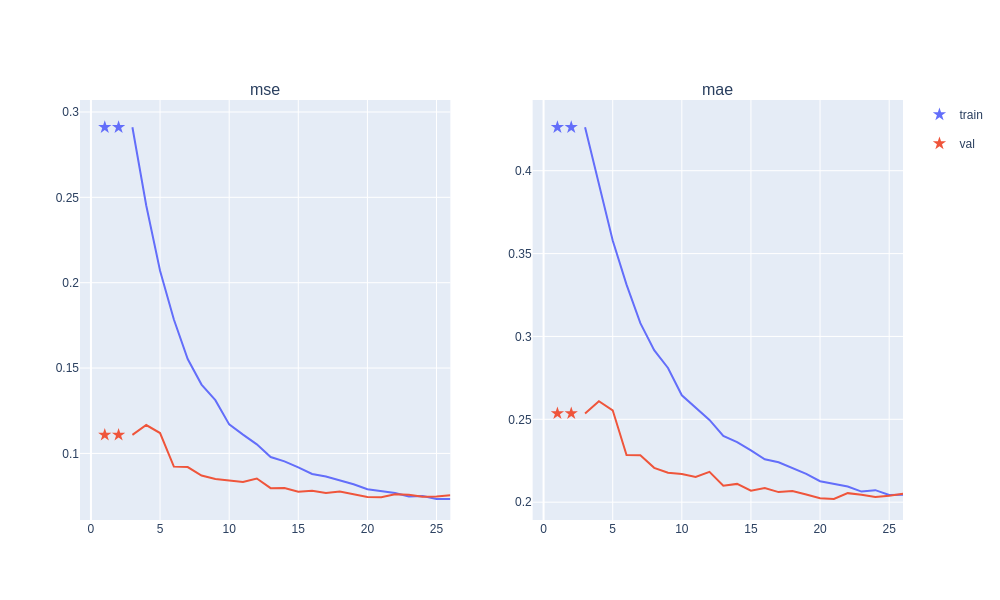


with pretrained embeddings
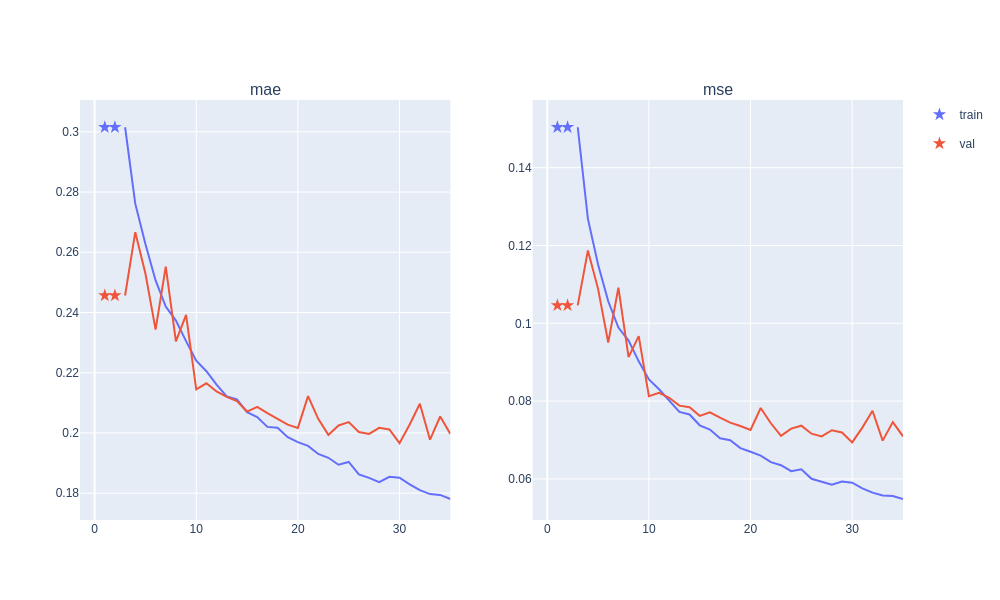

with attention
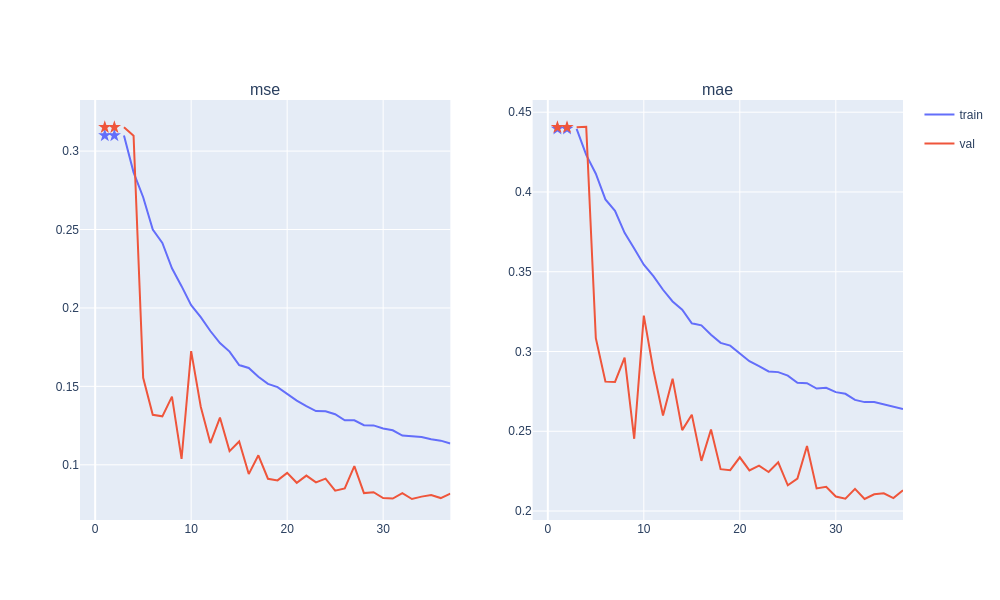

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) <s>Fun with words</s>

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) <s>Optimizing seriously</s>

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!